In [40]:
import sys
sys.path.append('../')

In [41]:
from scripts.utils import data_path, set_mpl
from scripts.read_data import read_weather_s22
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import h5py


#%matplotlib inline
%matplotlib widget

set_mpl()

matplotlib settings set


READ FROM /Users/sdbykov/not_work/swarm_energAIser/0_data/Hamelin/
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Hamelin/2018_weather.hdf5
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Hamelin/2019_weather.hdf5
LOADING WEATHER: /Users/sdbykov/not_work/swarm_energAIser/0_data/Hamelin/2020_weather.hdf5


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_60083/549956850.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_filled['homes_num'] = energy_filled.count(axis=1)
/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_60083/549956850.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_filled['P_TOT_AVG'] = energy_filled[orig_cols].sum(axis=1)/energy_filled['homes_num']
/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_60083/549956850.py:19: SettingWithCopyWarning: 

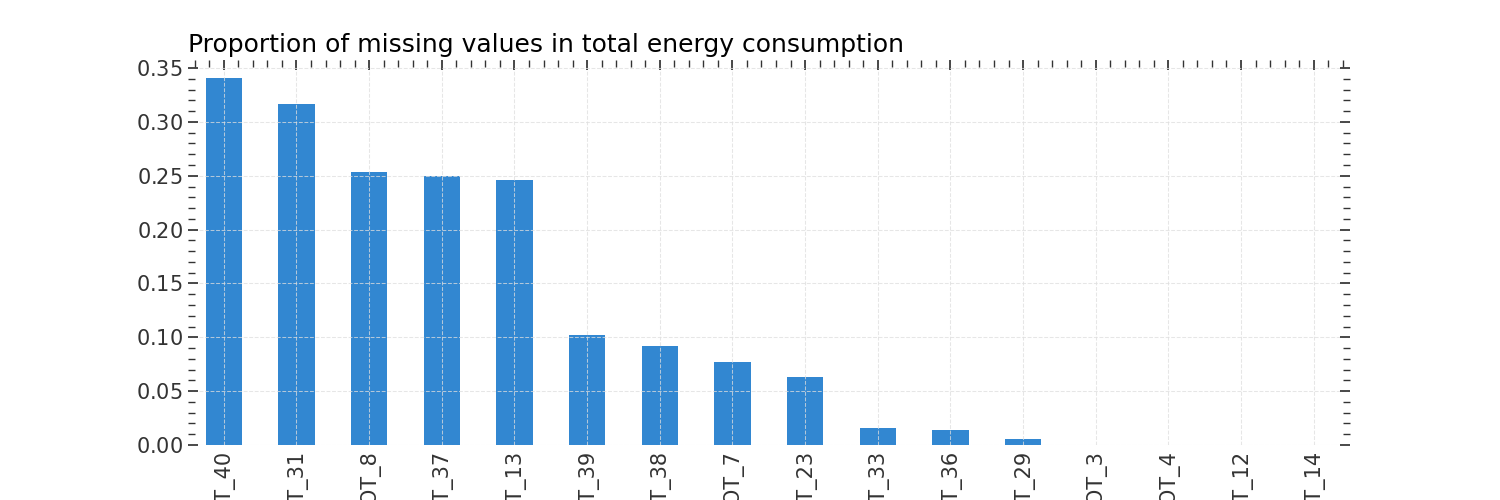

In [42]:
weather = read_weather_s22()

cluster_one = list(metadata.query('inhabitants==2 & area<=200 & area>=100 & index not in [6,17,24,25]').index)


cols_from_cluster_one = [f'P_TOT_{i}' for i in cluster_one]
energy[cols_from_cluster_one]


energy = pd.read_pickle(data_path+'Hamelin/energy_cluster_one.pkl')


missed_frac = energy.isna().mean(axis=0).sort_values(ascending=False)
missed_frac.plot(kind='bar', figsize=(15, 5), title='Proportion of missing values in total energy consumption')

energy_filled = energy[energy.columns[missed_frac < 0.2]]
orig_cols = [col for col in energy_filled.columns]


energy_filled['homes_num'] = energy_filled.count(axis=1)

energy_filled['P_TOT_AVG'] = energy_filled[orig_cols].sum(axis=1)/energy_filled['homes_num']


for df in [energy_filled]:
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear

    df['season'] = df['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
    df['workday'] = df['weekday'].apply(lambda x: 'workday' if x in [0, 1, 2, 3, 4] else 'weekend')

    datetime_cols  = ['hour', 'weekday', 'month', 'year', 'doy', 'season', 'workday']


#imputing 

energy_filled[orig_cols] = energy_filled[orig_cols].fillna(energy_filled.groupby(by = ['month', 'weekday', 'hour']).transform('median'))

energy_filled.drop(columns=['homes_num']+datetime_cols, inplace=True)
energy_filled = energy_filled[[energy_filled.columns[-1]] + list(energy_filled.columns[:-1])]


# DARTS time series package

In [43]:
# corr = energy_filled.corr()

# plt.figure(figsize=(6, 6))
# sns.heatmap(corr, annot=False, fmt='.1f', cmap='coolwarm', vmin=-1, vmax=1)


## init darts

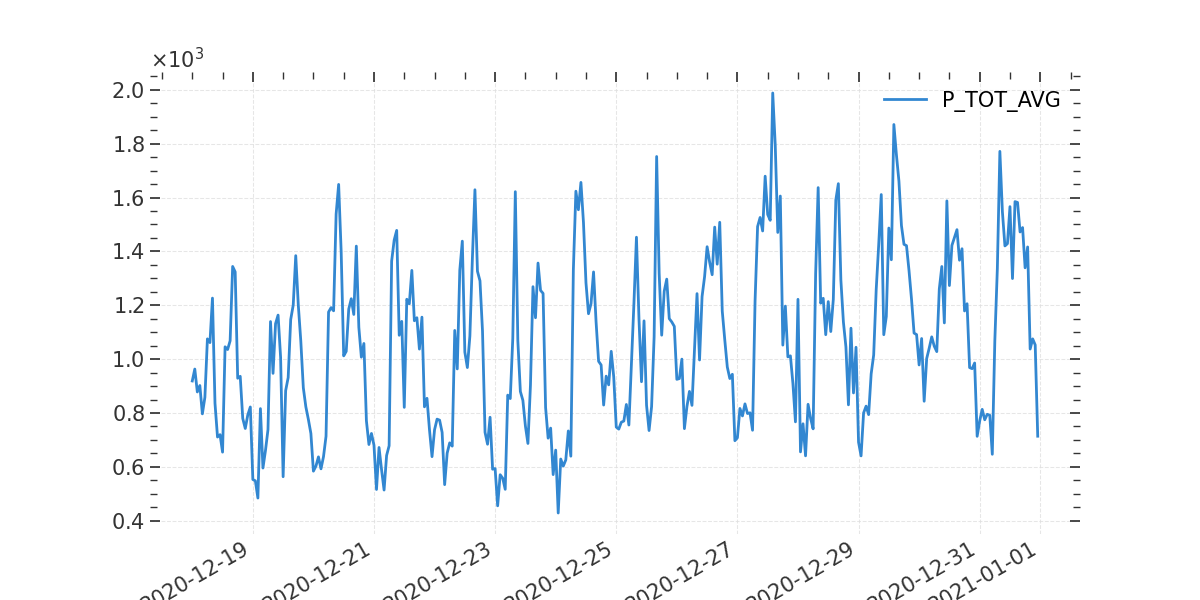

In [45]:
from darts import TimeSeries
from darts.metrics import mape
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr



#hierarchy: dict = { col: 'P_TOT_AVG' for col in energy_filled.columns[:-1] }

target_col = ['P_TOT_AVG']
covariates_col = [col for col in energy_filled.columns if col != target_col[0]]

target = TimeSeries.from_dataframe(energy_filled[target_col],freq='H') # multivariate time series

past_covariates = TimeSeries.from_dataframe(energy_filled[covariates_col],freq='H') # multivariate time series

weather_covariates = [TimeSeries.from_dataframe(weather[[col]], freq='H') for col in weather.columns]



hodidays_covariates = target.add_holidays("DE", state = "NI")['holidays']

#datetime attributes
#you can try using either one-hot or cyclic encoding instead of default (no encoding)
datetime_covatiates = concatenate(
    [
        dt_attr(time_index = target.time_index, attribute =  "hour", one_hot = False, cyclic = False )/24,
        dt_attr(time_index = target.time_index, attribute =  "day_of_week", one_hot = False, cyclic = False )/7,
        dt_attr(time_index = target.time_index, attribute =  "month", one_hot = False, cyclic = False )/12,
        dt_attr(time_index = target.time_index, attribute =  "day_of_year", one_hot = False, cyclic = False )/365,
    ],
    axis="component",
)

#static covariates: e.g. house number, number of occupants, etc. 

fig,  ax =  plt.subplots( figsize = (12,6))
target.tail(168*2).plot(ax = ax)



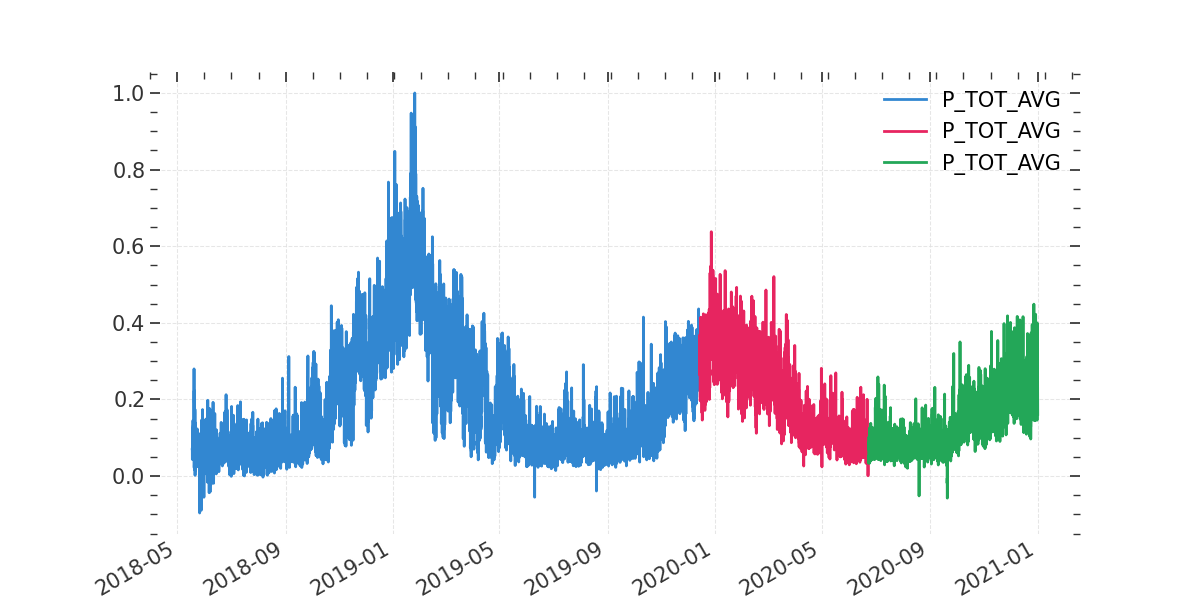

In [28]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, mase

from sklearn.preprocessing import MaxAbsScaler


train, val = target.split_before(0.6)
val, test = val.split_before(0.5)

scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

val_len = len(val)


fig,  ax =  plt.subplots( figsize = (12,6))

train.plot(ax = ax)
val.plot(ax = ax)
test.plot(ax = ax)



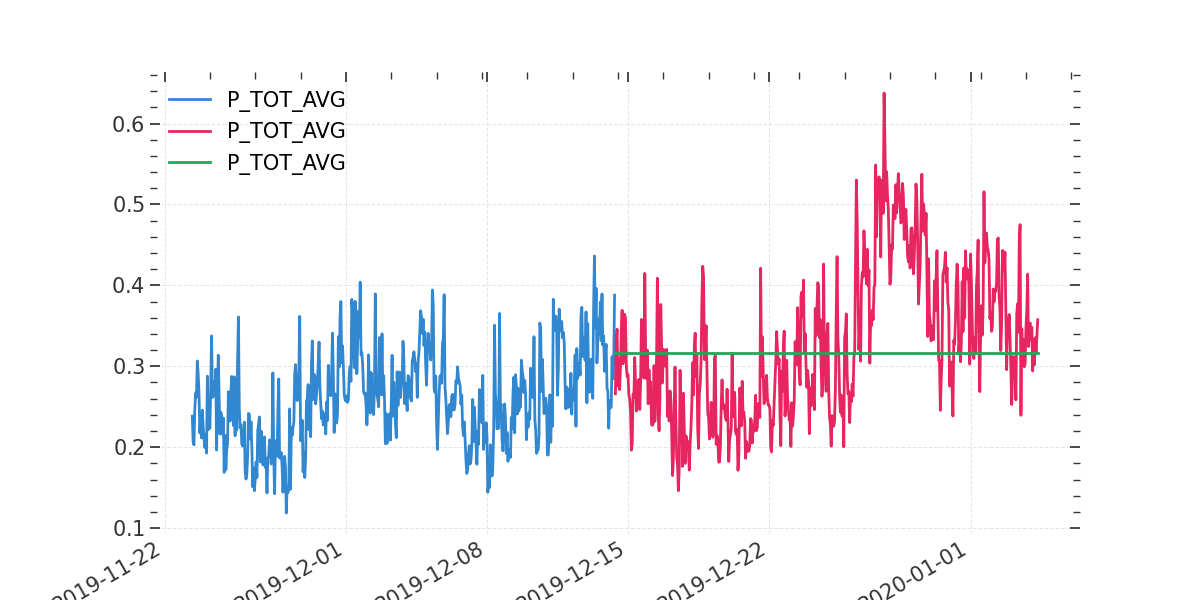

In [39]:
from darts.models import RandomForest 

model = RandomForest(lags = 5,  n_estimators = 100, max_depth = 2)
model.fit(train,)

#model = RandomForest(lags = 5, lags_future_covariates = [24], n_estimators = 100, max_depth = 2)
#future_covariates = datetime_covatiates)


pred = model.predict(n = len(val))

fig,  ax =  plt.subplots( figsize = (12,6))

train.tail(24*7*3).plot(ax = ax)
val.head(24*7*3).plot(ax = ax)
pred.head(24*7*3).plot(ax = ax)